# Voxel preparation

Runs in bkg and signal data files, 

Centers every event at origin

Labels class, segclass, ext and provides a unique index (idx) to the events

Group the voxels event data in bunches. For each bunch of events there is a h5 file. Files are ordered with increased index of events.

**J. A. Hernando 02/08/2024**


In [2]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy     as np
import pandas    as pd
from   scipy     import stats
import os
import matplotlib.pyplot as plt

In [4]:
import xyimg.voxelsprep as vp


## Debug

In [5]:
df1 = pd.DataFrame({'file_id':[1, 1, 2, 2], 'event':[0, 1, 2, 3], 'E':[10, 11, 12, 13]})
df2 = pd.DataFrame({'file_id':[1, 1, 2, 2], 'event':[0, 1, 2, 3], 'E':[20, 21, 22, 23]})
dfs = [df1, df2]

In [6]:
gs = [x.groupby(['file_id', 'event']) for x in dfs]

In [7]:
keys = vp.get_keys(gs)
print(keys)

[(0, (1, 0)), (0, (1, 1)), (0, (2, 2)), (0, (2, 3)), (1, (1, 0)), (1, (1, 1)), (1, (2, 2)), (1, (2, 3))]


In [8]:
for ievt, evt in vp.evt_iter(gs, nevents = 2, shuffle = True):
    print(ievt, evt)

(0, (1, 1))    file_id  event   E
1        1      1  11
(0, (1, 0))    file_id  event   E
0        1      0  10
(1, (1, 0))    file_id  event   E
0        1      0  20
(1, (1, 1))    file_id  event   E
1        1      1  21


## Voxels-Code Debug

In [9]:
ipath = os.environ['LPRDATADIR']

pressure  = '5bar'
sample    = '1eroi'

bkgfilename = vp.filename_voxel(pressure, '1eroi')
sigfilename = vp.filename_voxel(pressure, '0nubb') 

In [10]:
df1 = pd.read_hdf(ipath + bkgfilename, 'voxels')
df2 = pd.read_hdf(ipath + sigfilename, 'voxels')

In [11]:
dfs = [df1, df2]
gs  = [df.groupby(['file_id', 'event']) for df in dfs]

In [12]:
from sys import getsizeof
print(f"data size {getsizeof(gs[0])/1e6} Mb")

data size 4.8e-05 Mb


In [18]:
nevents = 5
shuffle = True
_int = lambda x : int(x.unique())
for i, ievt in enumerate(vp.evt_iter(gs, nevents, shuffle)):
    idevt, evt = ievt
    print('>>> Event ', i, idevt)
    print('number of voxels ', len(evt), ', file id', _int(evt['file_id']),
          ', event ', _int(evt['event']), ', class ', _int(evt['binclass']))

>>> Event  0 (1, (1, 1))
number of voxels  396 , file id 1 , event  1 , class  1
>>> Event  1 (0, (1, 2))
number of voxels  447 , file id 1 , event  2 , class  0
>>> Event  2 (0, (1, 1))
number of voxels  434 , file id 1 , event  1 , class  0
>>> Event  3 (1, (1, 4))
number of voxels  429 , file id 1 , event  4 , class  1
>>> Event  4 (1, (1, 0))
number of voxels  396 , file id 1 , event  0 , class  1
>>> Event  5 (1, (1, 2))
number of voxels  427 , file id 1 , event  2 , class  1
>>> Event  6 (1, (1, 3))
number of voxels  347 , file id 1 , event  3 , class  1
>>> Event  7 (0, (1, 0))
number of voxels  490 , file id 1 , event  0 , class  0
>>> Event  8 (0, (1, 4))
number of voxels  463 , file id 1 , event  4 , class  0
>>> Event  9 (0, (1, 3))
number of voxels  498 , file id 1 , event  3 , class  0


In [26]:
ofilename = 'vtemp.h5'
nbunch    = 5
nevents   = 10
shuffle   = True


def _save(kdf, ibunch):
    print('proceesed bunch ', ibunch)
    words = ofilename.split('.')
    smain, stail = words
    ofile = smain + '_bunch' + str(ibunch)+'.'+stail
    kdf.to_hdf(ofile, 'voxels')
    print('saved processed bunch data at:', ofile)
    ibunch += 1
    return ibunch

def _concat(kdf, kevt, k):
    kdf = pd.concat((kdf, kevt)) if k == 0 else kevt
    k  += 1
    return kdf, k

# load the data
ibunch = 0

# loop in the events
kdf, k = None, 0
for i, ievt in enumerate(vp.evt_iter(gs, nevents = nevents, shuffle = shuffle)):

    if  (k > 0) & (k % nbunch == 0): 
        print('events in the bunch ', k)
        ibunch = _save(kdf, ibunch)
        kdf, k = None, 0
    if (i >=0) & (i %1 == 0):  print('processed event ', i, ', id ', idevt)

    idevt, evt  = ievt
    kevt        = vp.evt_preparation(evt)
    kevt['idx'] = i
    kdf, k      = _concat(kdf, kevt, k)
    
if  (k > 0): 
    print('events in the bunch ', k)
    ibunch = _save(kdf, ibunch)

processed event  0 , id  (0, (1, 6))
processed event  1 , id  (1, (1, 5))
processed event  2 , id  (1, (1, 1))
processed event  3 , id  (0, (1, 0))
processed event  4 , id  (1, (1, 2))
events in the bunch  5
proceesed bunch  0
saved processed bunch data at: vtemp_bunch0.h5
processed event  5 , id  (0, (1, 7))
processed event  6 , id  (1, (1, 3))
processed event  7 , id  (1, (1, 8))
processed event  8 , id  (1, (1, 0))
processed event  9 , id  (0, (1, 5))
events in the bunch  5
proceesed bunch  1
saved processed bunch data at: vtemp_bunch1.h5
processed event  10 , id  (0, (1, 8))
processed event  11 , id  (0, (1, 9))
processed event  12 , id  (1, (1, 7))
processed event  13 , id  (1, (1, 9))
processed event  14 , id  (1, (1, 4))
events in the bunch  5
proceesed bunch  2
saved processed bunch data at: vtemp_bunch2.h5
processed event  15 , id  (0, (1, 1))
processed event  16 , id  (1, (1, 6))
processed event  17 , id  (0, (1, 3))
processed event  18 , id  (0, (1, 4))
processed event  19 ,

In [45]:
ifiles    = [ipath + bkgfilename, ipath + sigfilename]
ofile     = 'vptemp.h5'
nbunch    = 5
nevents   = 10
shuffle   = True
vp.run(ifiles, ofile, shuffle, nbunch, nevents)

input  filename       ['/scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_1eroi.h5', '/scratch/next/data/NEXT100/pressure_topology/voxel_dataset_5bar_0nubb.h5']
output filename       vptemp.h5
shuffle               True
nbunch                5
events                10
processed event  0 , id  (0, (1, 2))
proceesed bunch  0
events in the bunch  5
saved processed bunch data at: vptemp_bunch0.h5
proceesed bunch  1
events in the bunch  5
saved processed bunch data at: vptemp_bunch1.h5
proceesed bunch  2
events in the bunch  5
saved processed bunch data at: vptemp_bunch2.h5
proceesed bunch  3
events in the bunch  5
saved processed bunch data at: vptemp_bunch3.h5
events processed   19 
bunches processed  4 
time per event    1.34  s
time execution        48.8  s
done!


In [46]:
import glob
glob.glob('/home/jahernando/NEXT/software/nextnn/vptemp/*.h5')

['/home/jahernando/NEXT/software/nextnn/vptemp/vptemp_bunch0.h5',
 '/home/jahernando/NEXT/software/nextnn/vptemp/vptemp_bunch1.h5',
 '/home/jahernando/NEXT/software/nextnn/vptemp/vptemp_bunch2.h5',
 '/home/jahernando/NEXT/software/nextnn/vptemp/vptemp_bunch3.h5']

In [35]:
import xyimg.cnn as cnn

In [47]:
root = '/home/jahernando/NEXT/software/nextnn/vptemp/vptemp_bunch*.h5'

In [76]:
cc = cnn.Shot(root)

setting file  3
setting file  0


In [77]:
len(cc)

20

In [78]:
cc.bins

array([ 0,  5, 10, 15, 20])

In [79]:
np.digitize([0, 4, 5, 20], cc.bins)

array([1, 1, 2, 5])

In [85]:
kevt = cc[1]

0


In [86]:
kevt

,file_id,event,x,y,z,E,binclass,segclass,track_id,nhits,ext,idx
2332,1,5,-29.472941,-14.534118,1.534118,0.004931,0,1,0,2,1,1
2333,1,5,-29.472941,-13.534118,1.534118,0.005666,0,1,0,3,1,1
2334,1,5,-29.472941,-12.534118,0.534118,0.004058,0,1,0,2,1,1
2335,1,5,-29.472941,-11.534118,0.534118,0.008269,0,1,0,2,1,1
2336,1,5,-29.472941,-10.534118,-0.465882,0.002118,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2752,1,5,32.527059,-15.534118,-28.465882,0.003902,0,1,0,2,1,1
2753,1,5,33.527059,-15.534118,-27.465882,0.003146,0,1,0,2,1,1
2754,1,5,34.527059,-15.534118,-27.465882,0.003018,0,1,0,2,1,1
2755,1,5,34.527059,-15.534118,-26.465882,0.004764,0,1,0,1,1,1


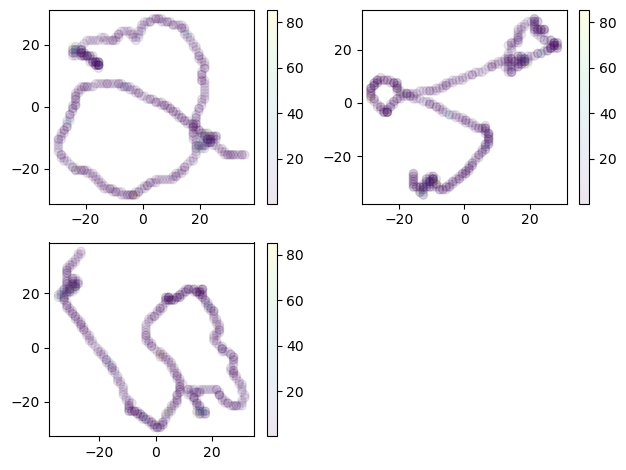

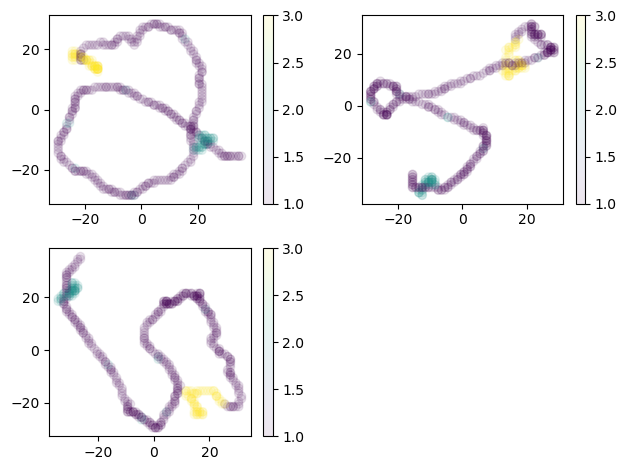

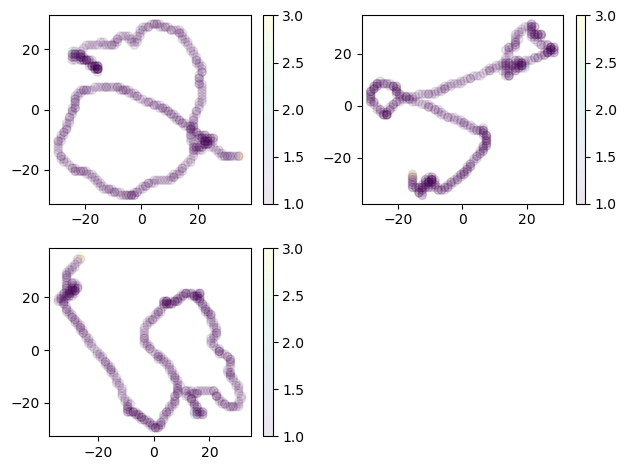

In [87]:
color = 1e3*kevt.E
plt.figure()
plt.subplot(2, 2, 1); plt.scatter(kevt.x, kevt.y, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 2); plt.scatter(kevt.y, kevt.z, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 3); plt.scatter(kevt.z, kevt.x, c = color, alpha = 0.1); plt.colorbar()
plt.tight_layout()
color = kevt.segclass
plt.figure()
plt.subplot(2, 2, 1); plt.scatter(kevt.x, kevt.y, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 2); plt.scatter(kevt.y, kevt.z, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 3); plt.scatter(kevt.z, kevt.x, c = color, alpha = 0.1); plt.colorbar()
plt.tight_layout()
color = kevt.ext
plt.figure()
plt.subplot(2, 2, 1); plt.scatter(kevt.x, kevt.y, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 2); plt.scatter(kevt.y, kevt.z, c = color, alpha = 0.1); plt.colorbar()
plt.subplot(2, 2, 3); plt.scatter(kevt.z, kevt.x, c = color, alpha = 0.1); plt.colorbar()
plt.tight_layout()


In [68]:
len(evt)

0

In [57]:
bins = np.linspace(0, len(cc), 5, endpoint = True, dtype = int)

In [60]:
np.digitize(10, bins)

3

In [49]:
d0 = pd.read_hdf(cc.root.replace('*', str(0)), 'voxels')


In [50]:
d0['idx'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
np.arange(cc.nbunches * cc.nevents)